This is an adaptation of Diehl&Cook's MNIST classification with STDP plasticity, by I. Balafrej, assistant for the course GEI723, Université de Sherbrooke, Oct. 2019, under the supervision of Prof. J. Rouat.

The paper is available here: https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full

The model is slightly simplified and mostly re-wrote with modern Brian2 & python 3.

In [2]:
import numpy as np
from sklearn import datasets, model_selection
from brian2 import *
import matplotlib.pyplot as plt
%matplotlib inline

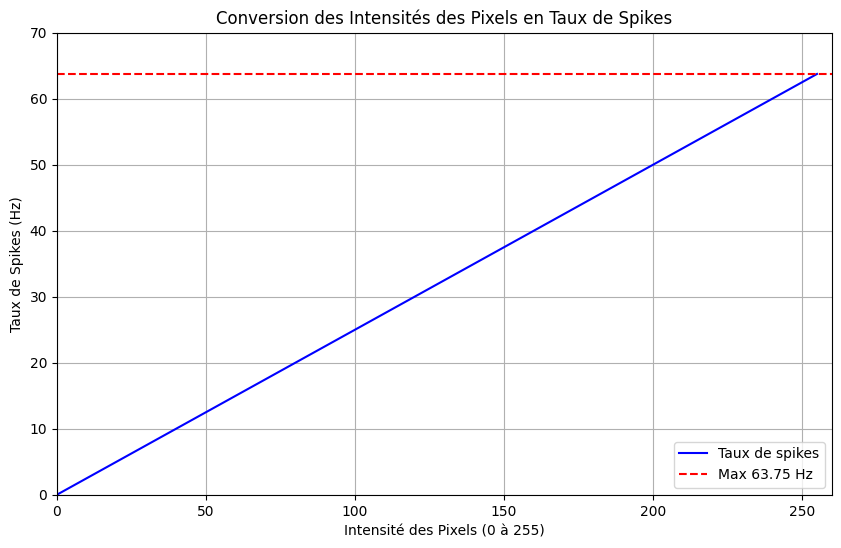

In [3]:
#Question 1 : codage de l'entree

# Définir les intensités des pixels de 0 à 255
pixel_intensities = np.arange(0, 256)

# Calculer le taux de spikes en Hz
spike_rates = pixel_intensities / 4

# Tracer la courbe
plt.figure(figsize=(10, 6))
plt.plot(pixel_intensities, spike_rates, label='Taux de spikes', color='blue')
plt.title('Conversion des Intensités des Pixels en Taux de Spikes')
plt.xlabel('Intensité des Pixels (0 à 255)')
plt.ylabel('Taux de Spikes (Hz)')
plt.xlim(0, 260)
plt.ylim(0, 70)
plt.axhline(y=63.75, color='r', linestyle='--', label='Max 63.75 Hz')
plt.legend()
plt.grid()
plt.show()


In [4]:
# Let's download the MNIST dataset, available at https://www.openml.org/d/554
# You can edit the argument data_home to the directory of your choice.
# The dataset will be downloaded there; the default directory is ~/scikit_learn_data/
np.random.seed(0)

X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home=None)

In [5]:

X.shape, y.shape # We should have 70k 28px*28px images of digits with 70k labels


((70000, 784), (70000,))

In [7]:

# Since the simulation is currently quite long, let's just use a subset of MNIST
# X = X[:1000]
# y = y[:1000]

#PRENDRE CORRECTEMENT LES DONNEES DE LA BASE DE DONNEES
num_classes = 10

# Sélectionner 700 images par classe
X_balanced = []
y_balanced = []

for class_label in range(num_classes):
    indices = np.where(y.astype(int) == class_label)[0]
    #print(f"Classe {class_label}: {len(indices)} indices trouvés.")
    n_samples = min(700, len(indices))  # 10% de chaque entree
    print(f"Classe {class_label}: {n_samples} échantillons sélectionnés.")
    selected_indices = np.random.choice(indices, size=n_samples, replace=False)
    
    X_balanced.append(X.iloc[selected_indices])
    y_balanced.append(y.iloc[selected_indices])


# Convertir les listes en tableaux NumPy
X_balanced = np.vstack(X_balanced)
y_balanced = np.concatenate(y_balanced)

# Mélanger les données
shuffled_indices = np.random.permutation(X_balanced.shape[0])
X_balanced = X_balanced[shuffled_indices]
y_balanced = y_balanced[shuffled_indices]

# Afficher les formes des tableaux résultants
print(X_balanced.shape, y_balanced.shape) 
print("10 premiers labels de y_balanced :", y_balanced[:10])



Classe 0: 700 échantillons sélectionnés.
Classe 1: 700 échantillons sélectionnés.
Classe 2: 700 échantillons sélectionnés.
Classe 3: 700 échantillons sélectionnés.
Classe 4: 700 échantillons sélectionnés.
Classe 5: 700 échantillons sélectionnés.
Classe 6: 700 échantillons sélectionnés.
Classe 7: 700 échantillons sélectionnés.
Classe 8: 700 échantillons sélectionnés.
Classe 9: 700 échantillons sélectionnés.
(7000, 784) (7000,)
10 premiers labels de y_balanced : ['8' '8' '4' '9' '2' '6' '8' '9' '6' '4']


In [8]:
# Let's split the dataset into a training and test set to validate the accuracy of 
# our model after training. We keep 10k images+labels for testing.

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("len of X_train:", len(X_train))
print("len of X_test:", len(X_test))

Shape of X_train: (5600, 784)
Shape of X_test: (1400, 784)
len of X_train: 5600
len of X_test: 1400


index: 1453


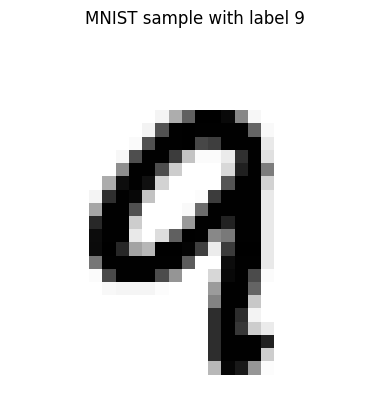

In [10]:
# We can try and plot one of the images to see what we're working with
index = np.random.randint(0, len(X_train)-1)
print("index:", index)
plt.figure()
plt.axis('off')
plt.imshow(X_train[index].reshape(28, 28), cmap=plt.cm.gray_r)
plt.title("MNIST sample with label %s" % y_train[index]);

In [13]:
# We now create our Brian2 network
# First, let's set-up some parameters
defaultclock.dt = 0.5 * units.ms
prefs.codegen.target = 'cython'
np.random.seed(0)
time_per_sample =   0.35 * units.second # Durée pour chaque échantillon , entree sur 350 ms
resting_time = 0.15 * units.second #Temps de repos entre les échantillons 

v_rest_e = -70 * units.mV  # Potentiel de repos
v_rest_i = -65 * units.mV 
v_reset_e = -70 * units.mV# Potentiel de réinitialisation
v_reset_i = -60* units.mV
v_thresh_e = -50. * units.mV# Seuil de décharge
v_thresh_i = -45. * units.mV
refrac_e = 5 * units.ms# Période réfractaire
refrac_i = 2 * units.ms

tc_theta = 20* units.ms #Homoeostasis
theta_plus_e = 2 * units.mV

tc_pre_ee = 20 * units.ms
tc_post_1_ee = 20 * units.ms #Pas sure!! , moi j ai utiliser pour ext
tc_post_2_ee = 20 * units.ms # pour inhib?

nu_ee_pre =  0.005      # learning rate
nu_ee_post = 0.005

# POUR LA STDP
w_max = .01
dpre = .01 
dpost1 = -dpre * tc_pre_ee / tc_post_1_ee * 1.05# j ai utilise  tc_post_1_ee mais 2 cas ?
dpost1 *= w_max
dpre *= w_max







In [14]:
# Our input will simply be a ... ToBeFilled ... encoder
#input_group = ToBeFilled(28*28, ToBeFilled)
n_input_neurons = 28 * 28  # 1 neurone par pixel
duration = 350 * ms 
eqs = """
rates : Hz
v : volt
"""
input_group = NeuronGroup(n_input_neurons,
                          eqs,
                          threshold='v_thresh_e',
                          reset='v = v_reset_e',
                          refractory=refrac_e,
                          method='linear')

input_group.v = v_rest_e
input_group.rates = 0 * units.Hz

# ou ? input_group = PoissonGroup(n_input_neurons, rates=spike_rates * Hz)


In [16]:
# We now define the neuron model
neuron_model = '''
    dv/dt =  (Erest - V + I_synE + I_synI ) / tau   : volt (unless refractory)
    I_synE = ge * (Eexc - v) : amp
    I_synI = gi * (Einh - v) : amp
    dge/dt = -ge/tc_post_1_ee : 1
    dgi/dt = -gi/tc_post_2_ee : 1
    tau : second (constant, shared)
    d_I_synI : volt (constant, shared)
    dtheta/dt = (theta_plus_e-theta)/tc_theta  : volt
    Erest : volt
    Eexc: volt
    Einh: volt
'''
#Erest = v_rest_e ou v_rest_i
#Eexc = 0? Na+
#Einh = -80 ? Cl- ( potentiel d equilibre)
#?????????????????????????????????????


# Varier le nombre de neurones: 100, 400, 1600, 6400
Nb_Neurones_Couche = 400

excitatory_group = NeuronGroup(
    N=Nb_Neurones_Couche, model=neuron_model, refractory=refrac_e, 
    threshold='v > v_thresh_e', reset='v = v_reset_e; theta += theta_plus_e', method='euler')
excitatory_group.tau = tc_post_1_ee
excitatory_group.d_I_synI = -5 * units.mV #éviter que les neurones excitateurs soient trop inhibés, petit ?????
excitatory_group.Erest = v_rest_e
excitatory_group.Eexc = 0* units.mV
excitatory_group.Einh = -80* units.mV


inhibitory_group = NeuronGroup(
    N=Nb_Neurones_Couche, model=neuron_model, refractory=refrac_i, 
    threshold='v > v_thresh_i', reset='v = v_reset_i', method='euler')
inhibitory_group.tau = tc_post_2_ee
inhibitory_group.d_I_synI = -5 * mV #éviter que les neurones inhibiteurs soient trop inhibés, petit ?????
inhibitory_group.Erest = v_rest_i
inhibitory_group.Eexc = 0* units.mV
inhibitory_group.Einh = -80* units.mV

In [18]:
# And then the synapses
synapse_model = "w : 1"
stdp_synapse_model = '''
    w : 1
    plastic : boolean (shared) # Activate/deactivate plasticity
    post2before : 1
    dpre/dt   =   -pre / tc_pre_ee : 1 (event-driven)
    dpost1/dt  = -post1 / tc_post_1_ee  : 1 (event-driven)
    
'''
# ToBeFilled? eq en plus?

# en cours? w = clip(ToBeFilled)
stdp_pre = '''
ge_post += w
pre += dpre.
w = clip(w + post1, 0, w_max)
'''

# en cours?
stdp_post = '''
post2before += dpost1
w = clip(w + pre, 0, w_max)
'''


# Créer les synapses d'entrée

#EN COURS
input_synapse = Synapses(input_group,excitatory_group,  on_pre=stdp_pre, on_post=stdp_post, model=stdp_synapse_model)
input_synapse.connect(True) # Fully connected ERREUR ICI !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
input_synapse.delay = '1.0 * ms'#?
input_synapse.plastic = True
input_synapse.w = 'rand() * 0.05'#?

# Synapses excitatrices -> inhibitrices

e_i_synapse = Synapses(excitatory_group, inhibitory_group, on_pre='gi_post += w', model=stdp_synapse_model)
e_i_synapse.connect(True, p=0.0025)
e_i_synapse.w = 'rand()*10.4'

# Synapses inhibitrices -> excitatrices

i_e_synapse = Synapses(inhibitory_group, excitatory_group,on_pre='ge_post -= w', model=stdp_synapse_model)
i_e_synapse.connect(True, p=0.9)
i_e_synapse.w = 'rand()*17.0'

In [19]:
print(len(input_synapse) + len(e_i_synapse) + len(i_e_synapse))

458154


In [20]:
# Readout
e_monitor = SpikeMonitor(excitatory_group, record=False)

In [21]:
# Creating the network
net = Network(input_group, excitatory_group, inhibitory_group, 
              input_synapse, e_i_synapse, i_e_synapse, e_monitor)

In [25]:
# We create a recording array to assign the labels after training
spikes = np.zeros((10, len(excitatory_group)))
# We can't reset e_monitor, so we subtract the old value with old_spike_counts
old_spike_counts = np.zeros(len(excitatory_group))

# Training
number_of_epochs = 1
for i in range(number_of_epochs):
    print('Starting iteration %i' % i)
    for j, (sample, label) in enumerate(zip(X_train, y_train)):
        if (j % 10) == 0:
            print("Running sample %i out of %i" % (j, len(X_train)))

        print("label",label)
        # Set the input rate
        #input_group.rates = ToBeFilled
        pixel_intensities = sample
        input_group.rates = spike_rates[pixel_intensities] / 4* Hz  
        print(f"Input rates for sample {j}: {input_group.rates}")
        # Run learning
        net.run(time_per_sample)# ERREUR DANS LA DEFINITION DU MODELE DE NEURONES' VERIF DEFINITION DE TT VARIABLE !!!!!
        
        # Record weights
        spikes[int(label)] += e_monitor.count - old_spike_counts
        old_spike_counts = np.copy(e_monitor.count)
        
        # Remove input
        input_group.rates = 0 * units.Hz
        
        # Let the variables return to resting potential
        net.run(resting_time)
        
        # Normalize the weights
        print("Weights before normalization:")
        print(weight_matrix)
        #weight_matrix = np.zeros(ToBeFilled)
        weight_matrix = np.zeros((len(input_group), len(excitatory_group)))
        weight_matrix[input_synapse.i, input_synapse.j] = input_synapse.w
        


        #ToBeFilled !!!!!!!!!!!!!!!!!!!!!!
        #ToBeFilled
        for j in range(len(excitatory_group)):
            weight_matrix[:,j] *= 1#colFactors[j]#colFactors[j]
        input_synapse.w = weight_matrix[input_synapse.i, input_synapse.j]

Starting iteration 0
Running sample 0 out of 5600
label 8
Input rates for sample 0: <neurongroup.rates: array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0. 

BrianObjectException: Error encountered with object named 'neurongroup_2'.
Object was created here (most recent call only, full details in debug log):
  File 'C:\Users\cllam\AppData\Local\Temp\ipykernel_15716\2627359656.py', line 24, in <module>
    excitatory_group = NeuronGroup(

An error occurred when preparing an object. (See above for original error message and traceback.)

In [14]:
# Time to test !
# First, we figure out the best neurons for our labels
labeled_neurons = np.argmax(spikes, axis=1)
labeled_neurons

array([327, 257,  38,  71, 269,  28,  36, 356, 129, 224])

In [15]:
input_synapse.plastic = False # Remove STDP plasticity
num_correct_output = 0
for i, (sample, label) in enumerate(zip(X_test, y_test)):
    if (i % 10) == 0:
        print("Running sample %i out of %i" % (i, len(X_test)))
    # Set the input rate
    input_group.rates = sample / 4. * units.Hz
    
    # Run model
    net.run(time_per_sample)
    
    # Calculate the spike count for this sample
    current_spike_count = e_monitor.count - old_spike_counts
    old_spike_counts = np.copy(e_monitor.count)
    
    # Get the predicted label
    output_label = np.argmax(ToBeFilled)
    
    if output_label == int(label):
        num_correct_output += 1
        
    # Let the variables return to resting potential
    net.run(resting_time)
    
print("The model accuracy is : %.3f" % (num_correct_output / len(X_test)))    

Running sample 0 out of 750
Running sample 10 out of 750
Running sample 20 out of 750
Running sample 30 out of 750
Running sample 40 out of 750
Running sample 50 out of 750
Running sample 60 out of 750
Running sample 70 out of 750
Running sample 80 out of 750
Running sample 90 out of 750
Running sample 100 out of 750
Running sample 110 out of 750
Running sample 120 out of 750
Running sample 130 out of 750
Running sample 140 out of 750
Running sample 150 out of 750
Running sample 160 out of 750
Running sample 170 out of 750
Running sample 180 out of 750
Running sample 190 out of 750
Running sample 200 out of 750
Running sample 210 out of 750
Running sample 220 out of 750
Running sample 230 out of 750
Running sample 240 out of 750
Running sample 250 out of 750
Running sample 260 out of 750
Running sample 270 out of 750
Running sample 280 out of 750
Running sample 290 out of 750
Running sample 300 out of 750
Running sample 310 out of 750
Running sample 320 out of 750
Running sample 330 ou